<a href="https://colab.research.google.com/github/thaisrezendeb/ufes_machineLearning/blob/main/Exercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2) Dada a base de dados CNAE_9_reduzido (em anexo):
**a) gere um gráfico 2D com os dois componentes principais (uso de PCA) das amostras, identificando cada classe (a base possui 5 classes. O rótulo das amostras está na primeira coluna. Essa coluna não deve ser usada no PCA). Pode usar a função eig do Matlab ou outra função para obter os autovalores e autovetores.**

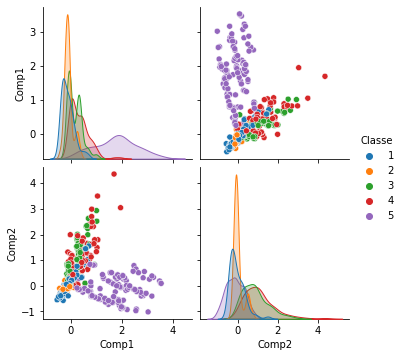

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

cnae9 = pd.read_csv("CNAE_9_reduzido.txt", sep=" ", header=None)
pos_class = 0

#Teste com a base Iris
#cnae9 = pd.read_csv("iris.data", sep=",", header=None)
#pos_class = 4

#Remove coluna com dados de classificação
cnae9_noclass = cnae9.drop(pos_class, axis=1)
cnae9_noclass.columns = range(cnae9_noclass.shape[1])
#cnae9.shape
#cnae9_noclass.shape

#Cálculo das médias para cada componente
medias_cnae9_noclass = np.mean(cnae9_noclass, axis=0)

#Faz a normalização dos valores (X^)
cnae9_noclass_norm = cnae9_noclass - medias_cnae9_noclass

#Calcula a matriz de covariância dos componentes normalizados (C)
matriz_cov = cnae9_noclass_norm.T.dot(cnae9_noclass_norm) / (cnae9_noclass_norm.shape[0]-1)

#Obtém os autovalores (lambda) e autovetores (V)
autovalores, autovetores = np.linalg.eigh(matriz_cov)

#Monta uma matriz contendo duas colunas: a primeira o autovalor e a segunda seu respectivo autovetor
matriz_auto = [
               (
                   autovalores[i],
                   autovetores[:,i]
               ) for i in range(len(autovalores))
]

#Ordena matriz de forma decrescente
df_auto = pd.DataFrame(matriz_auto)
df_auto.sort_values(by=0, ascending=False, inplace=True)
#df_auto.head()
matriz_auto = df_auto.to_numpy()

n_comp = 2 #Número de componentes para gerar gráfico bidimensional
autovetores_ord = [p[1] for p in matriz_auto]

#Uso de apenas os dois primeiros autovetores
autovetores_filtered = (autovetores_ord[0:n_comp])

#Reapresenta as amostras sem normalização nos novos eixos
novo_cnae9_noclass = np.dot(cnae9_noclass, np.array(autovetores_filtered).T)

#Monta novo dataframe com amostras em novos eixos para o gráfico
novo_cnae9 = pd.DataFrame(novo_cnae9_noclass, columns=["Comp1", "Comp2"])
novo_cnae9["Classe"] = cnae9[pos_class].astype(str)
sns.pairplot(novo_cnae9, vars=["Comp1", "Comp2"], hue="Classe")

**b) gere um gráfico 2D usando o t-SNE (pode usar o código disponível em
https://lvdmaaten.github.io/tsne/ com os parâmetros default), identificando cada
classe (a base possui 5 classes). Lembre-se de não usar a coluna de rótulos para obter a
redução de dimensão.**

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 600...
Computing P-values for point 500 of 600...
Mean value of sigma: 0.929441


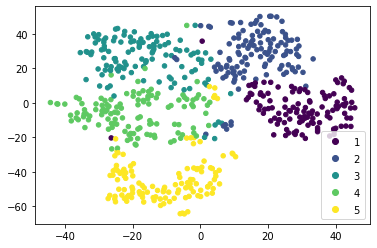

In [ ]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            #print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    #X = np.loadtxt("mnist2500_X.txt")
    X = cnae9_noclass
    #labels = np.loadtxt("mnist2500_labels.txt")
    labels = cnae9[0]
    Y = tsne(X, 2, 502, 20.0)
    scatter = pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.legend(*scatter.legend_elements(), loc="lower right")
    pylab.show()

**c) Utilize as primeiras 480 amostras para treinar o classificador vizinho mais próximo
(NN) (utilize a distância Euclidiana) e as demais 120 para teste. Calcule a métrica
acurácia e informe o valor obtido. Pelo resultado obtido, qual dos gráficos (t-SNE ou
PCA) você acha que melhor representou a “realidade” da distribuição dos dados? Por
quê?**

In [ ]:
def vizinho(base_train, base_test):
  acuracia = 0

  #Cálculo da distância Euclidiana
  #Verifica a distância de cada amostra da base de teste com cada uma das amostras da base de treinamento
  for i, row in base_test.iterrows():
    dist_min = 1000000
    classif_new = row[0]
    for j, row_next in base_train.iterrows():
      dist = 0
      for k in range(1, base_test.shape[1]-1):
        dist = dist + np.power(row_next[k]-row[k],2)

      dist = np.sqrt(dist)
      if dist < dist_min:
        dist_min = dist
        classif_new = row_next[0]
    
    if row[0] == classif_new:
      acuracia = acuracia + 1

  acuracia = np.divide(acuracia, base_test.shape[0])

  return acuracia

In [ ]:
cnae9_train = cnae9[:480]
cnae9_test = cnae9[480:]
ac_viz = vizinho(cnae9_train, cnae9_test)
print("Acurácia NN: {:.2f}%".format(ac_viz*100))

Acurácia NN: 95.83%


O classificador do vizinho mais próximo (NN) usando a distância Euclidiana apresentou uma acurácia de **95,83%**. Para esta condição, conclui-se que o modelo t-SNE é o que melhor representa as amostras, pois há uma melhor distribuição das classes, permitindo uma separação mais clara entre elas. No método PCA as amostras de diferentes classes estão mais misturadas o que aumenta a chance de falha na classificação.

In [ ]:
##Validação do algoritmo
#from sklearn.decomposition import  PCA

#df = cnae9
#X = cnae9_noclass
#Y = cnae9[pos_class]

#pca = PCA(n_components=2)
#pca.fit(X)

#X = pca.transform(X)
#new_df = pd.DataFrame(X, columns=["pc1", "pc2"])
#new_df["target"] = df[pos_class].astype("str")
#sns.pairplot(new_df, vars=["pc1", "pc2"], hue="target")